In [5]:
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
import heapq

# ==================== 1. Генерация лабиринтов ====================

def generate_maze(width, height, complexity=0.1):
    """Генерация лабиринта с помощью алгоритма DFS"""
    maze = np.ones((height, width), dtype=int)
    
    # Начальная точка
    stack = [(1, 1)]
    maze[1, 1] = 0
    
    while stack:
        current = stack[-1]
        neighbors = []
        
        for dx, dy in [(0, 2), (2, 0), (0, -2), (-2, 0)]:
            nx, ny = current[0] + dx, current[1] + dy
            if 0 < nx < height-1 and 0 < ny < width-1 and maze[nx, ny] == 1:
                neighbors.append((nx, ny))
        
        if neighbors:
            next_cell = random.choice(neighbors)
            wall_x = (current[0] + next_cell[0]) // 2
            wall_y = (current[1] + next_cell[1]) // 2
            maze[wall_x, wall_y] = 0
            maze[next_cell[0], next_cell[1]] = 0
            stack.append(next_cell)
        else:
            stack.pop()
    
    # Добавляем случайные стены для усложнения
    for _ in range(int(complexity * width * height)):
        x, y = random.randint(1, height-2), random.randint(1, width-2)
        if (x, y) not in [(1, 1), (height-2, width-2)]:
            maze[x, y] = 1
    
    return maze

# ==================== 2. A* для генерации данных ====================

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar_path(maze, start, goal):
    """Поиск оптимального пути методом A*"""
    neighbors = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    
    heapq.heappush(oheap, (fscore[start], start))
    
    while oheap:
        current = heapq.heappop(oheap)[1]
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        close_set.add(current)
        
        for dx, dy in neighbors:
            neighbor = current[0] + dx, current[1] + dy
            tentative_g_score = gscore[current] + 1
            
            if (0 <= neighbor[0] < maze.shape[0] and 
                0 <= neighbor[1] < maze.shape[1] and 
                maze[neighbor] == 0):
                
                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                    continue
                
                if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))
    
    return None

# ==================== 3. Токенизация и датасет ====================

class MazeTokenizer:
    def __init__(self, max_maze_size=20):
        self.max_size = max_maze_size
        self.vocab = {
            '#': 0,  # стена
            '.': 1,  # пусто
            'S': 2,  # старт
            'E': 3,  # выход
            'A': 4   # агент
        }
    
    def tokenize(self, maze, agent_pos, goal_pos):
        """Преобразует лабиринт в последовательность токенов с позиционным кодированием"""
        tokens = []
        positions = []
        
        for i in range(self.max_size):
            for j in range(self.max_size):
                if i >= maze.shape[0] or j >= maze.shape[1]:
                    token = self.vocab['#']  # вне границ = стена
                elif (i, j) == agent_pos:
                    token = self.vocab['A']
                elif (i, j) == goal_pos:
                    token = self.vocab['E']
                elif maze[i, j] == 1:
                    token = self.vocab['#']
                else:
                    token = self.vocab['.']
                
                tokens.append(token)
                positions.append([i, j])
        
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(positions, dtype=torch.float)

# ==================== 4. Архитектура Transformer ====================

class MazeTransformer(nn.Module):
    def __init__(self, vocab_size=5, d_model=128, nhead=8, num_layers=4, max_seq_len=400):
        super().__init__()
        
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Linear(2, d_model)  # Координаты (x, y) -> эмбеддинг
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=512, 
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Выходной слой для предсказания действия
        self.action_head = nn.Linear(d_model, 4)  # 4 действия: вверх, вниз, влево, вправо
        
        self.d_model = d_model
    
    def forward(self, tokens, positions):
        # tokens: (batch, seq_len)
        # positions: (batch, seq_len, 2)
        
        # Эмбеддинги токенов + позиционное кодирование
        token_emb = self.token_embed(tokens)  # (batch, seq_len, d_model)
        pos_emb = self.pos_embed(positions)   # (batch, seq_len, d_model)
        
        x = token_emb + pos_emb
        
        # Transformer
        x = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Получаем эмбеддинг агента (токена 'A')
        agent_mask = (tokens == 4).unsqueeze(-1)  # (batch, seq_len, 1)
        agent_embedding = (x * agent_mask).sum(dim=1)  # (batch, d_model)
        
        # Предсказываем действие
        action_logits = self.action_head(agent_embedding)
        return action_logits

# ==================== 5. Генерация обучающих данных ====================

# ---------- 3а. Утилита для «проходимого» лабиринта ----------
def generate_solvable_maze(w, h, max_attempts=20):
    """Генерирует лабиринт, в котором точно есть путь (1,1) -> (h-2,w-2)."""
    for _ in range(max_attempts):
        m = generate_maze(w, h, complexity=0.05)
        if astar_path(m, (1, 1), (h-2, w-2)) is not None:
            return m
    # если не получилось — возвращаем «пустой» коридор
    m = np.ones((h, w), dtype=int)
    m[1:h-1, 1] = 0
    m[h-2, 1:w-1] = 0
    return m

# ---------- 3b. Обновлённая генерация данных ----------
def generate_training_data(num_samples=1000, maze_size=10):
    data = []
    tokenizer = MazeTokenizer(max_maze_size=maze_size)

    attempts = 0
    while len(data) < num_samples:
        attempts += 1
        maze = generate_solvable_maze(maze_size, maze_size)
        start, goal = (1, 1), (maze_size-2, maze_size-2)
        path = astar_path(maze, start, goal)

        # если A* не справился – делаем фальшивый «прямой» путь
        if path is None or len(path) < 2:
            path = [start]
            x, y = start
            while x < goal[0]:
                x += 1
                path.append((x, y))
            while y < goal[1]:
                y += 1
                path.append((x, y))

        # добавляем каждый шаг
        for i in range(len(path)-1):
            curr, nxt = path[i], path[i+1]
            dx, dy = nxt[0]-curr[0], nxt[1]-curr[1]
            action = {(-1,0):0, (1,0):1, (0,-1):2, (0,1):3}[(dx, dy)]

            tokens, positions = tokenizer.tokenize(maze, curr, goal)
            data.append({'tokens': tokens,
                         'positions': positions,
                         'action': action})

        if attempts % 100 == 0:
            print(f"Собрано {len(data)}/{num_samples} примеров")

    print(f"Готово: {len(data)} примеров")
    return data

# ==================== 6. Обучение модели ====================

def train_model(data, epochs=10, batch_size=32, lr=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Инициализация модели
    model = MazeTransformer(vocab_size=5, d_model=128, nhead=8, num_layers=4, 
                           max_seq_len=400).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # DataLoader
    def collate_fn(batch):
        tokens = torch.stack([item['tokens'] for item in batch])
        positions = torch.stack([item['positions'] for item in batch])
        actions = torch.tensor([item['action'] for item in batch], dtype=torch.long)
        return tokens, positions, actions
    
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           shuffle=True, collate_fn=collate_fn)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (tokens, positions, actions) in enumerate(dataloader):
            tokens, positions, actions = tokens.to(device), positions.to(device), actions.to(device)
            
            optimizer.zero_grad()
            logits = model(tokens, positions)
            loss = criterion(logits, actions)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch} completed, Average Loss: {avg_loss:.4f}")
    
    return model

# ==================== 7. Тестирование ====================

def test_model(model, maze_size=10, num_tests=5):
    device = next(model.parameters()).device
    tokenizer = MazeTokenizer(max_maze_size=maze_size)
    model.eval()
    
    for test in range(num_tests):
        # Генерируем новый лабиринт
        maze = generate_maze(maze_size, maze_size, complexity=0.05)
        start = (1, 1)
        goal = (maze_size-2, maze_size-2)
        
        current_pos = start
        path = [current_pos]
        max_steps = maze_size * maze_size * maze_size * maze_size
        
        for step in range(max_steps):
            # Получаем предсказание
            tokens, positions = tokenizer.tokenize(maze, current_pos, goal)
            tokens, positions = tokens.unsqueeze(0).to(device), positions.unsqueeze(0).to(device)
            
            with torch.no_grad():
                logits = model(tokens, positions)
                action = torch.argmax(logits, dim=1).item()
            
            # Выполняем действие
            action_map = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
            dx, dy = action_map[action]
            next_pos = (current_pos[0] + dx, current_pos[1] + dy)
            
            # Проверяем валидность
            if (0 <= next_pos[0] < maze.shape[0] and 
                0 <= next_pos[1] < maze.shape[1] and 
                maze[next_pos] == 0):
                current_pos = next_pos
                path.append(current_pos)
                
                if current_pos == goal:
                    print(f"Test {test+1}: SUCCESS! Path length: {len(path)}")
                    break
            else:
                # Невалидное действие
                pass
        
        else:
            print(f"Test {test+1}: FAILED - Max steps reached")
        
        # Показываем траекторию
        print_maze_with_path(maze, path, goal)

def print_maze_with_path(maze, path, goal):
    """Визуализация лабиринта с пройденным путем"""
    maze_vis = maze.copy().astype(str)
    maze_vis[maze == 1] = '#'
    maze_vis[maze == 0] = '.'
    
    for i, (x, y) in enumerate(path):
        if (x, y) != goal:
            maze_vis[x, y] = str(i % 10)
    
    maze_vis[goal] = 'E'
    print('\n'.join([''.join(row) for row in maze_vis]))
    print()

# ==================== 8. Запуск всего пайплайна ====================

if __name__ == "__main__":
    # Параметры
    MAZE_SIZE = 10
    NUM_TRAIN_SAMPLES = 2000
    EPOCHS = 15
    BATCH_SIZE = 32
    
    print("1. Генерация обучающих данных...")
    train_data = generate_training_data(num_samples=NUM_TRAIN_SAMPLES, maze_size=MAZE_SIZE)
    print(f"Сгенерировано {len(train_data)} примеров")
    
    print("\n2. Обучение модели...")
    model = train_model(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    print("\n3. Тестирование...")
    test_model(model, maze_size=MAZE_SIZE, num_tests=3)

1. Генерация обучающих данных...
Собрано 1400/2000 примеров
Готово: 2002 примеров
Сгенерировано 2002 примеров

2. Обучение модели...
Using device: cpu
Epoch 0, Batch 0, Loss: 1.1356
Epoch 0, Batch 50, Loss: 0.1320
Epoch 0 completed, Average Loss: 0.2752
Epoch 1, Batch 0, Loss: 0.0149
Epoch 1, Batch 50, Loss: 0.0151
Epoch 1 completed, Average Loss: 0.0602
Epoch 2, Batch 0, Loss: 0.0168
Epoch 2, Batch 50, Loss: 0.0759
Epoch 2 completed, Average Loss: 0.0263
Epoch 3, Batch 0, Loss: 0.0653
Epoch 3, Batch 50, Loss: 0.0023
Epoch 3 completed, Average Loss: 0.0165
Epoch 4, Batch 0, Loss: 0.0033
Epoch 4, Batch 50, Loss: 0.0018
Epoch 4 completed, Average Loss: 0.0105
Epoch 5, Batch 0, Loss: 0.0054
Epoch 5, Batch 50, Loss: 0.0089
Epoch 5 completed, Average Loss: 0.0029
Epoch 6, Batch 0, Loss: 0.0024
Epoch 6, Batch 50, Loss: 0.0085
Epoch 6 completed, Average Loss: 0.0344
Epoch 7, Batch 0, Loss: 0.0045
Epoch 7, Batch 50, Loss: 0.0018
Epoch 7 completed, Average Loss: 0.0067
Epoch 8, Batch 0, Loss: 0

In [17]:
def test_model(model, maze_size=100, num_tests=5, eps=0.05):
    device = next(model.parameters()).device
    tokenizer = MazeTokenizer(max_maze_size=maze_size)
    model.eval()

    for test in range(num_tests):
        # 1. точно проходимый лабиринт
        maze = generate_solvable_maze(maze_size, maze_size)
        start, goal = (1, 1), (maze_size-2, maze_size-2)

        pos = start
        path = [pos]
        collisions = 0
        max_steps = maze_size * maze_size * 3

        for step in range(max_steps):
            tokens, positions = tokenizer.tokenize(maze, pos, goal)
            tokens, positions = tokens.unsqueeze(0).to(device), positions.unsqueeze(0).to(device)

            with torch.no_grad():
                logits = model(tokens, positions)
            # ε-greedy: с вероятностью ε выбираем случайный допустимый ход
            valid_actions = []
            for a, (dx, dy) in enumerate([(-1, 0), (1, 0), (0, -1), (0, 1)]):
                nx, ny = pos[0]+dx, pos[1]+dy
                if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and maze[nx, ny] == 0:
                    valid_actions.append(a)

            if not valid_actions:          # теоретически невозможно
                break

            #if random.random() < eps:
            action = random.choice(valid_actions)
            #else:
                # маскируем недопустимые действия логитом -1e9
                #masked = logits.clone()
                #masked[0, [a for a in range(4) if a not in valid_actions]] = -1e9
                #action = masked.argmax(1).item()

            # делаем шаг
            dx, dy = [(-1, 0), (1, 0), (0, -1), (0, 1)][action]
            new_pos = (pos[0]+dx, pos[1]+dy)
            if new_pos == goal:
                print(f"Test {test+1}: SUCCESS  steps={len(path)}  collisions={collisions}")
                break
            if maze[new_pos] == 0:          # свободная клетка
                pos = new_pos
                path.append(pos)
            else:                            # столкновение
                collisions += 1
        else:
            # провал – выводим подробности
            print(f"Test {test+1}: FAILED  final_pos={pos}  steps={len(path)}  collisions={collisions}")
            print_maze_with_path(maze, path, goal)

print("\n3. Тестирование...") 
test_model(model, maze_size=MAZE_SIZE, num_tests=3)


3. Тестирование...
Test 1: SUCCESS  steps=250  collisions=0
Test 2: SUCCESS  steps=234  collisions=0
Test 3: SUCCESS  steps=90  collisions=0


In [19]:
# 3-D maze transformer
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
import heapq
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------------- 1. 3-D Maze generation ----------------
def generate_3d_maze(L, H, D, complexity=0.05):
    """L=width, H=height, D=depth.  Returns np.uint8 0=free, 1=wall."""
    maze = np.ones((H, L, D), dtype=np.uint8)

    # DFS carving
    stack = [(1,1,1)]
    maze[1,1,1] = 0
    while stack:
        x,y,z = stack[-1]
        nbr = []
        for dx,dy,dz in [(0,0,2),(0,2,0),(2,0,0),(0,0,-2),(0,-2,0),(-2,0,0)]:
            nx,ny,nz = x+dx, y+dy, z+dz
            if 0<nx<H-1 and 0<ny<L-1 and 0<nz<D-1 and maze[nx,ny,nz]:
                nbr.append((nx,ny,nz))
        if nbr:
            nx,ny,nz = random.choice(nbr)
            maze[(x+nx)//2, (y+ny)//2, (z+nz)//2] = 0
            maze[nx,ny,nz] = 0
            stack.append((nx,ny,nz))
        else:
            stack.pop()

    # random extra walls
    for _ in range(int(complexity*L*H*D)):
        xx = random.randint(1,H-2); yy = random.randint(1,L-2); zz = random.randint(1,D-2)
        if (xx,yy,zz) != (1,1,1) and (xx,yy,zz) != (H-2,L-2,D-2):
            maze[xx,yy,zz] = 1
    return maze

# ---------------- 2. 3-D A* ----------------
def heuristic_3d(a,b):  # Manhattan
    return abs(a[0]-b[0]) + abs(a[1]-b[1]) + abs(a[2]-b[2])

def astar_3d(maze, start, goal):
    """Returns list of (x,y,z) positions or None."""
    neigh = [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]
    open_heap = [(heuristic_3d(start,goal), 0, start)]
    came_from = {}
    cost = {start:0}
    while open_heap:
        f,g,cur = heapq.heappop(open_heap)
        if cur == goal:  # reconstruct
            path = [cur]
            while cur in came_from:
                cur = came_from[cur]
                path.append(cur)
            return path[::-1]
        for dx,dy,dz in neigh:
            nxt = (cur[0]+dx, cur[1]+dy, cur[2]+dz)
            if 0<=nxt[0]<maze.shape[0] and 0<=nxt[1]<maze.shape[1] and 0<=nxt[2]<maze.shape[2] and maze[nxt]==0:
                new_g = g+1
                if nxt not in cost or new_g<cost[nxt]:
                    cost[nxt]=new_g
                    came_from[nxt]=cur
                    heapq.heappush(open_heap, (new_g+heuristic_3d(nxt,goal), new_g, nxt))
    return None

def generate_solvable_3d(L,H,D):
    for _ in range(20):
        m = generate_3d_maze(L,H,D, complexity=0.03)
        if astar_3d(m,(1,1,1),(H-2,L-2,D-2)) is not None:
            return m
    # fallback – straight corridor
    m = np.ones((H,L,D),dtype=np.uint8)
    m[1:-1,1,1]=0; m[-2,1:-1,1]=0; m[-2,-2,1:-1]=0
    return m

# ---------------- 3. Tokenizer (3-D) ----------------
class Maze3DTokenizer:
    def __init__(self, max_L=10, max_H=10, max_D=10):
        self.max_shape = (max_H, max_L, max_D)
        self.vocab = {'#':0, '.':1, 'S':2, 'E':3, 'A':4}

    def tokenize(self, maze, agent_pos, goal_pos):
        H,L,D = self.max_shape
        tokens = []; pos3 = []
        for x in range(H):
            for y in range(L):
                for z in range(D):
                    if x>=maze.shape[0] or y>=maze.shape[1] or z>=maze.shape[2]:
                        t = 0  # wall outside
                    elif (x,y,z)==agent_pos:
                        t = self.vocab['A']
                    elif (x,y,z)==goal_pos:
                        t = self.vocab['E']
                    elif maze[x,y,z]==1:
                        t = self.vocab['#']
                    else:
                        t = self.vocab['.']
                    tokens.append(t)
                    pos3.append([x,y,z])
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(pos3, dtype=torch.float)

# ---------------- 4. 3-D Transformer ----------------
class Maze3DTransformer(nn.Module):
    def __init__(self, vocab=5, d=192, nhead=8, nlayers=4, max_len=1000):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab, d)
        self.pos_emb = nn.Linear(3, d)  # 3-D coordinates
        layer = nn.TransformerEncoderLayer(d_model=d, nhead=nhead, dim_feedforward=4*d, dropout=0.1, batch_first=True)
        self.trans = nn.TransformerEncoder(layer, nlayers)
        self.head = nn.Linear(d, 6)  # 6 actions: ±x,±y,±z
        self.d = d

    def forward(self, tokens, pos3):
        # tokens: (B,Seq)  pos3: (B,Seq,3)
        x = self.tok_emb(tokens) + self.pos_emb(pos3)
        x = self.trans(x)
        # агент = токен 'A'
        mask = (tokens==4).unsqueeze(-1)  # (B,Seq,1)
        agent_x = (x*mask).sum(dim=1)     # (B,d)
        return self.head(agent_x)         # (B,6)

# ---------------- 5. Data generation ----------------
def generate_3d_data(n_samples=2000, L=8, H=8, D=8):
    tokenizer = Maze3DTokenizer(max_L=L, max_H=H, max_D=D)
    data = []
    while len(data)<n_samples:
        maze = generate_solvable_3d(L,H,D)
        start, goal = (1,1,1), (H-2,L-2,D-2)
        path = astar_3d(maze, start, goal)
        if path is None or len(path)<2:
            continue
        for i in range(len(path)-1):
            curr,nxt = path[i], path[i+1]
            dx,dy,dz = nxt[0]-curr[0], nxt[1]-curr[1], nxt[2]-curr[2]
            action = {(1,0,0):0,(-1,0,0):1,(0,1,0):2,(0,-1,0):3,(0,0,1):4,(0,0,-1):5}[(dx,dy,dz)]
            tok, pos = tokenizer.tokenize(maze, curr, goal)
            data.append({'tokens':tok, 'positions':pos, 'action':action})
    print(f'3-D dataset ready: {len(data)} samples')
    return data

# ---------------- 6. Train ----------------
def train(model, data, epochs=10, batch=32, lr=1e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    loader = torch.utils.data.DataLoader(data, batch_size=batch, shuffle=True,
                                        collate_fn=lambda b: (
                                            torch.stack([x['tokens'] for x in b]),
                                            torch.stack([x['positions'] for x in b]),
                                            torch.tensor([x['action'] for x in b], dtype=torch.long)))
    model.train()
    for epoch in range(epochs):
        total=0
        for tok,pos,act in loader:
            tok,pos,act = tok.to(device), pos.to(device), act.to(device)
            opt.zero_grad()
            logits = model(tok, pos)
            loss = loss_fn(logits, act)
            loss.backward(); opt.step()
            total+=loss.item()
        print(f'Epoch {epoch}  loss={total/len(loader):.4f}')
    return model

# ---------------- 8. Run ----------------
if __name__ == '__main__':
    L=H=D=8
    data = generate_3d_data(n_samples=50, L=L, H=H, D=D)
    model = Maze3DTransformer(vocab=5, d=192, nhead=8, nlayers=4, max_len=L*H*D).to(device)
    model = train(model, data, epochs=12, batch=32)

3-D dataset ready: 60 samples
Epoch 0  loss=1.8803
Epoch 1  loss=1.3066
Epoch 2  loss=1.0818
Epoch 3  loss=1.0527
Epoch 4  loss=0.9341
Epoch 5  loss=0.8237
Epoch 6  loss=0.7939
Epoch 7  loss=0.7282
Epoch 8  loss=0.6193
Epoch 9  loss=0.5539
Epoch 10  loss=0.4794
Epoch 11  loss=0.4447
Test 1: SUCCESS  steps=15
Test 2: SUCCESS  steps=15
Test 3: SUCCESS  steps=19
Test 4: SUCCESS  steps=15
3-D tests finished


In [30]:
# ------------------------------------------------------------
# 1. Сбор визуальных объектов для Plotly
# ------------------------------------------------------------
# ---------- 1. Хаотичный 3-D лабиринт + случайный выход ----------
def generate_3d_maze_prim(L, H, D):
    """Randomized Prim для 3-D. Возвращает maze и СЛУЧАЙНЫЙ свободный goal."""
    maze = np.ones((H, L, D), dtype=np.uint8)
    # старт
    sx, sy, sz = 1, 1, 1
    maze[sx, sy, sz] = 0
    walls = []
    def add_w(x, y, z, dx, dy, dz):
        nx, ny, nz = x + 2 * dx, y + 2 * dy, z + 2 * dz
        if 1 <= nx < H - 1 and 1 <= ny < L - 1 and 1 <= nz < D - 1:
            walls.append((x, y, z, dx, dy, dz))

    for d in [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]:
        add_w(sx, sy, sz, *d)

    while walls:
        x, y, z, dx, dy, dz = walls.pop(random.randrange(len(walls)))
        nx, ny, nz = x + 2 * dx, y + 2 * dy, z + 2 * dz
        if maze[nx, ny, nz] == 1:  # ещё не посещена
            maze[x + dx, y + dy, z + dz] = 0  # пробиваем стену
            maze[nx, ny, nz] = 0  # отмечаем клетку
            for d in [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]:
                add_w(nx, ny, nz, *d)

    # случайный свободный goal
    free = list(zip(*np.where(maze == 0)))
    goal = random.choice(free)
    # чтобы не совпало со стартом
    while goal == (sx, sy, sz):
        goal = random.choice(free)
    return maze, (sx, sy, sz), goal


def generate_solvable_3d(L, H, D):
    return generate_3d_maze_prim(L, H, D)  # возвращает (maze, start, goal)


# ---------- 2. Рисуем СВОБОДНЫЙ ОБЪЁМ цветом ----------
def maze_3d_traces(maze, path, start, goal):
    import plotly.graph_objects as go
    H, L, D = maze.shape
    data = []

    # 1) стены – серые кубики (код как был)
    for x in range(H):
        for y in range(L):
            for z in range(D):
                if maze[x, y, z] == 1:
                    xx = [x, x, x + 1, x + 1, x, x, x + 1, x + 1]
                    yy = [y, y + 1, y + 1, y, y, y + 1, y + 1, y]
                    zz = [z, z, z, z, z + 1, z + 1, z + 1, z + 1]
                    faces = [[0, 1, 2, 3], [4, 5, 6, 7], [0, 1, 5, 4],
                             [2, 3, 7, 6], [0, 3, 7, 4], [1, 2, 6, 5]]
                    for f in faces:
                        data.append(go.Mesh3d(
                            x=[xx[v] for v in f],
                            y=[yy[v] for v in f],
                            z=[zz[v] for v in f],
                            color='lightgrey', opacity=0.85,
                            name='wall' if len(data) == 0 else None, showlegend=len(data) == 0))

    # 2) свободные клетки – цвет = евклидово расстояние до старта
    free = np.argwhere(maze == 0)          # (N,3)
    dist = np.linalg.norm(free - np.array(start), axis=1)  # без scipy
    data.append(go.Scatter3d(
        x=free[:, 0] + 0.5, y=free[:, 1] + 0.5, z=free[:, 2] + 0.5,
        mode='markers',
        marker=dict(size=3, color=dist, colorscale='Plasma', opacity=0.4,
                    colorbar=dict(title='dist to start'), showscale=True),
        name='free space'))

    # 3) путь – красная линия
    px, py, pz = zip(*path)
    path_line = go.Scatter3d(x=px, y=py, z=pz,
                              mode='lines+markers',
                              line=dict(color='red', width=6),
                              marker=dict(size=4, color='red'),
                              name='path')

    # 4) старт / финиш
    start_pt = go.Scatter3d(x=[start[0]], y=[start[1]], z=[start[2]],
                            mode='markers', marker=dict(size=10, color='green', symbol='diamond'),
                            name='start')
    goal_pt = go.Scatter3d(x=[goal[0]], y=[goal[1]], z=[goal[2]],
                           mode='markers', marker=dict(size=10, color='blue', symbol='cross'),
                           name='goal')

    return data + [path_line, start_pt, goal_pt]
    
def show_3d_maze(maze, path, start, goal, title='3-D maze path'):
    traces = maze_3d_traces(maze, path, start, goal)
    import plotly.graph_objects as go
    fig = go.Figure(data=traces)
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'),
        margin=dict(l=0, r=0, t=30, b=0)
    )
    # можно открыть в браузере
    fig.show()
    # при желании сохранить:
    # fig.write_html('maze_3d.html'); print('saved → maze_3d.html')


# ------------------------------------------------------------
# 3. Добавляем вызов в конец test_3d
# ------------------------------------------------------------
def test_3d(model, L=8, H=8, D=8, tests=3, eps=0.05):
    tokenizer = Maze3DTokenizer(max_L=L, max_H=H, max_D=D)
    model.eval()
    for t in range(tests):
        maze, start, goal = generate_solvable_3d(L, H, D)   # <-- исправлено
        pos = start
        path = [pos]
        max_steps = L * H * D * 3
        for step in range(max_steps):
            tok, pos3 = tokenizer.tokenize(maze, pos, goal)
            tok, pos3 = tok.unsqueeze(0).to(device), pos3.unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(tok, pos3)

            valid = []
            for a, (dx, dy, dz) in enumerate([(1, 0, 0), (-1, 0, 0),
                                              (0, 1, 0), (0, -1, 0),
                                              (0, 0, 1), (0, 0, -1)]):
                nx, ny, nz = pos[0] + dx, pos[1] + dy, pos[2] + dz
                if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1] and 0 <= nz < maze.shape[2] and maze[nx, ny, nz] == 0:
                    valid.append(a)
            if not valid:
                break
            # ε-greedy
            act = random.choice(valid)

            dx, dy, dz = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)][act]
            new_pos = (pos[0] + dx, pos[1] + dy, pos[2] + dz)
            if new_pos == goal:
                print(f'Test {t+1}: SUCCESS  steps={len(path)}')
                show_3d_maze(maze, path + [new_pos], start, goal,
                             title=f'Test {t+1} SUCCESS, steps={len(path)}')
                break
            if maze[new_pos] == 0:
                pos = new_pos; path.append(pos)
        else:
            print(f'Test {t+1}: FAILED  final={pos}  steps={len(path)}')
            show_3d_maze(maze, path, start, goal,
                         title=f'Test {t+1} FAILED, steps={len(path)}')

Test 1: FAILED  final=(5, 1, 1)  steps=1537


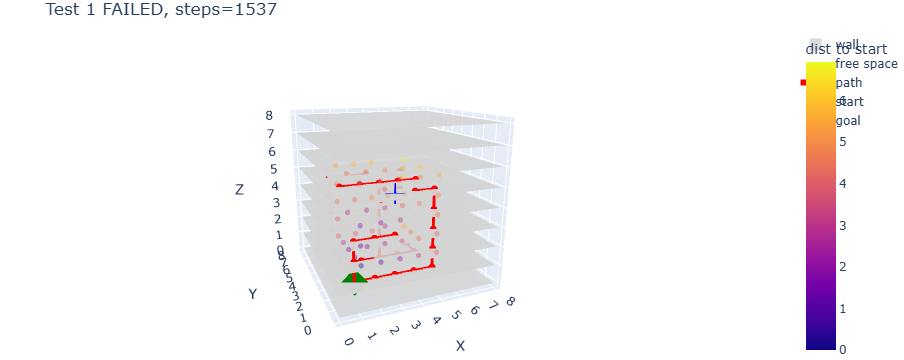

Test 2: SUCCESS  steps=530


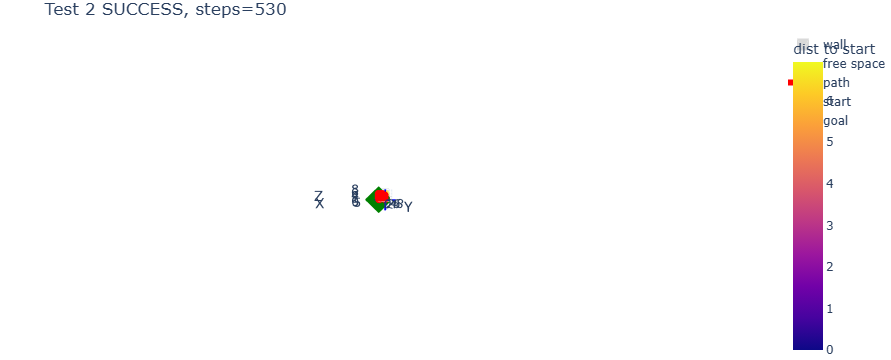

Test 3: SUCCESS  steps=375


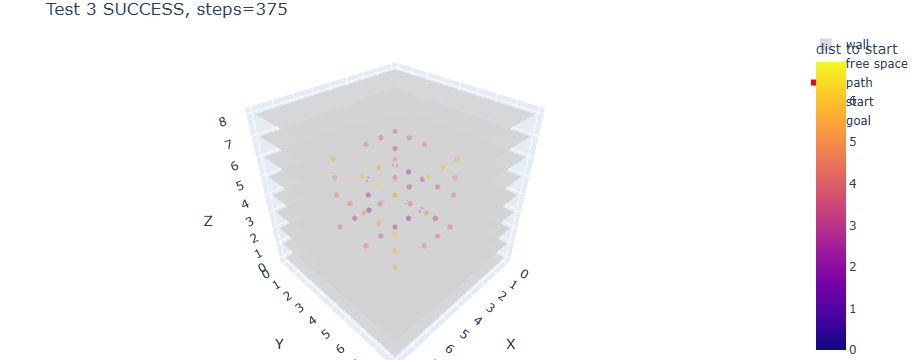

Test 4: SUCCESS  steps=326


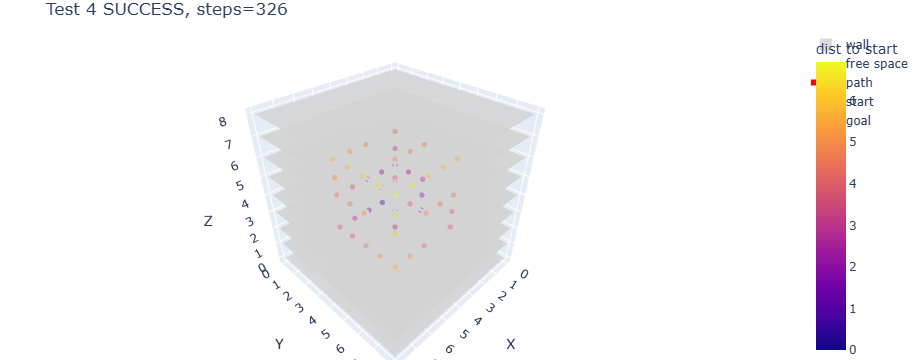

In [31]:
test_3d(model, L=L, H=H, D=D, tests=4)